In [69]:
import os

import numpy as np
import networkx as nx
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

datapath = "../data"
localdatapath = "../local_data"

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300

Load book dataset (requires that you have the books locally in `chapters.csv`)

In [70]:
df = pd.read_csv(os.path.join(localdatapath, "book.csv"), header=0, index_col=0)
df["names"] = df.apply(lambda r: eval(r["names"]), axis=1)
df.head(10)

,book,title,text,names
0,0,PROLOGUE,"PROLOGUE\n\n\n\n“We should start back,” Gared ...","[Jon Snow, Robert Baratheon]"
1,0,BRAN,BRAN\n\n\n\n\n\nThe morning had dawned clear a...,"[Jon Snow, Eddard 'Ned' Stark, Robert Baratheo..."
2,0,CATELYN,CATELYN\n\n\n\n\n\nCatelyn had never liked thi...,"[Eddard 'Ned' Stark, Jon Snow, Robert Baratheo..."
3,0,DAENERYS,DAENERYS\n\n\n\n\n\nHer brother held the gown ...,"[Jorah Mormont, Viserys Targaryen, Daenerys Ta..."
4,0,EDDARD,EDDARD\n\n\n\n\n\nThe visitors poured through ...,"[Robert Baratheon, Eddard 'Ned' Stark, Jon Sno..."
5,0,JON,"JON\n\n\n\n\n\nThere were times—not many, but ...","[Jon Snow, Robert Baratheon, Eddard 'Ned' Star..."
6,0,CATELYN,CATELYN\n\n\n\n\n\nOf all the rooms in Winterf...,"[Eddard 'Ned' Stark, Robert Baratheon, Jon Sno..."
7,0,ARYA,ARYA\n\n\n\n\n\nArya’s stitches were crooked a...,"[Jon Snow, Sansa Stark, Robb Stark, Joffrey Ba..."
8,0,BRAN,BRAN\n\n\n\n\n\nThe hunt left at dawn. The kin...,"[Jon Snow, Robert Baratheon, Eddard 'Ned' Star..."
9,0,TYRION,TYRION\n\n\n\n\n\nSomewhere in the great stone...,"[Eddard 'Ned' Stark, Robert Baratheon, Benjen ..."


Summary statistics about book chapters

In [71]:
print(f"""
Number of chapters: {len(df)}
Number of words:    {sum(len(c.split()) for c in df.text)}
Number of letters:  {sum(len(c) for c in df.text)}
""")


Number of chapters: 358
Number of words:    1741449
Number of letters:  9419747



Load redditor data (requires you have it locally)

In [ ]:
df_reddit = pd.read_csv(os.path.join(localdatapath, "asoiaf_data_cleaned.csv"), header=0, index_col=0)
df_reddit["names"] = df_reddit.apply(lambda r: eval(r["names"]), axis=1)
df_reddit.head(10)

In [ ]:
print(f"""
Number of posts:    {len(df_reddit)}
Number of words:    {sum(len(c.split()) for c in df_reddit.selftext)}
Number of letters:  {sum(len(c) for c in df_reddit.selftext)}
""")

Load both graphs built by `graphing.py`

In [26]:
G_book = nx.read_gpickle(os.path.join(datapath, "book.nxgraph"))
G_reddit = nx.read_gpickle(os.path.join(datapath, "asoiaf_data_cleaned.nxgraph"))

In [27]:
print(
f"""
Book character graph:
Nodes: {len(G_book.nodes())}
Edges: {len(G_book.edges())}
Avg. degree: {np.mean(list(d for _, d in G_book.degree()))}
""" 
)



Book character graph:
Nodes: 34
Edges: 483
Avg. degree: 28.41176470588235



In [28]:
print(
f"""
Reddit character graph:
Nodes:       {len(G_reddit.nodes())}
Edges:       {len(G_reddit.edges())}
Avg. degree: {np.mean(list(d for _, d in G_reddit.degree()))}
""" 
)


Reddit character graph:
Nodes:       34
Edges:       594
Avg. degree: 34.94117647058823



In [52]:
def plot_graph(G: nx.Graph, weight_cutoff: int = 0.1, max_node_size: int = 400, pos=None):
    H = G.copy() # H is G, just mutated for plotting

    H.remove_edges_from([e for e, w in nx.get_edge_attributes(H,'weight').items() if w < weight_cutoff] )
    edge_sizes = list(nx.get_edge_attributes(H,'weight').values())

    max_deg = max(d for _, d in H.degree()) 
    node_sizes = list((d/max_deg)**3 * max_node_size for _, d in H.degree()) # Scale polynomially node size with number of connections
    
    pos = nx.drawing.layout.kamada_kawai_layout(H) if pos is None else pos
    fig, ax = plt.subplots(figsize=(16, 9))

    nx.draw_networkx_nodes(H, pos=pos, ax=ax, node_size=node_sizes, node_color="r")
    nx.draw_networkx_edges(H, pos=pos, ax=ax, edge_color=edge_sizes, edge_cmap=plt.cm.Oranges)
    nx.draw_networkx_labels(H, pos=pos, ax=ax, font_family="serif", font_size=10, horizontalalignment="center", verticalalignment="top")

    plt.show()
    return pos

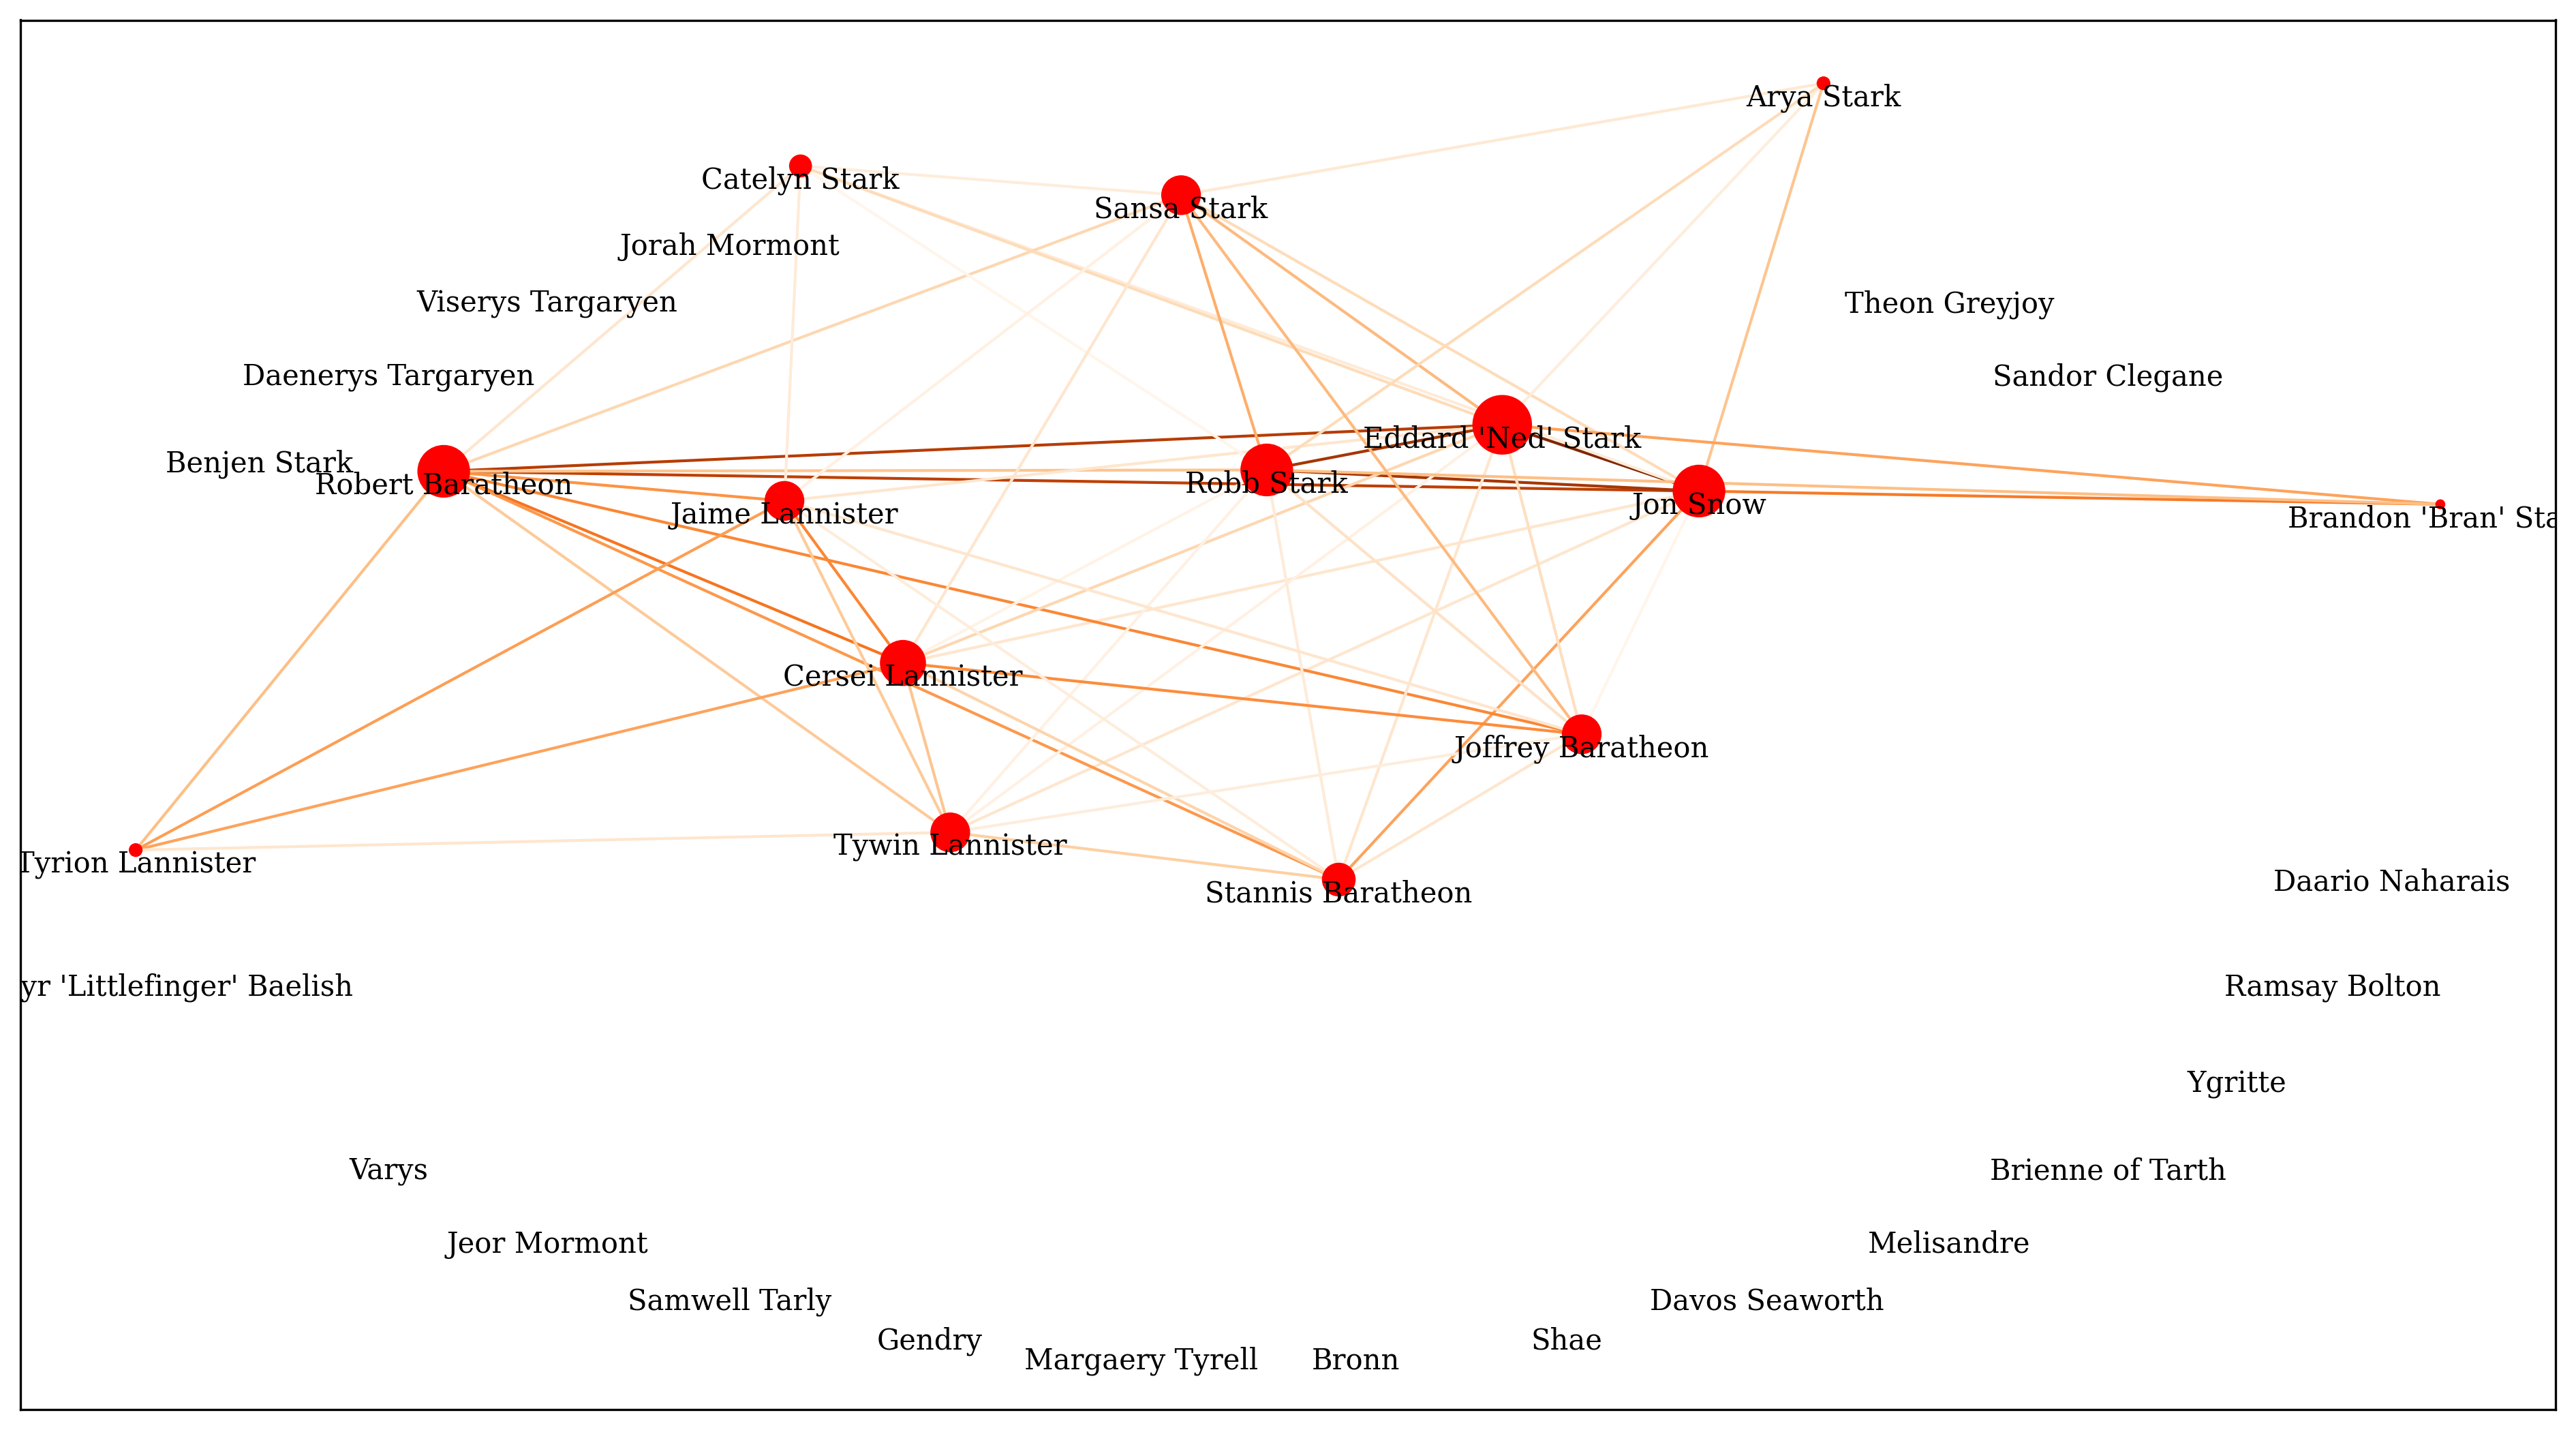

In [60]:
"""
INITIAL BOOK GRAPH
"""

pos = plot_graph(G_book, weight_cutoff=0.6)

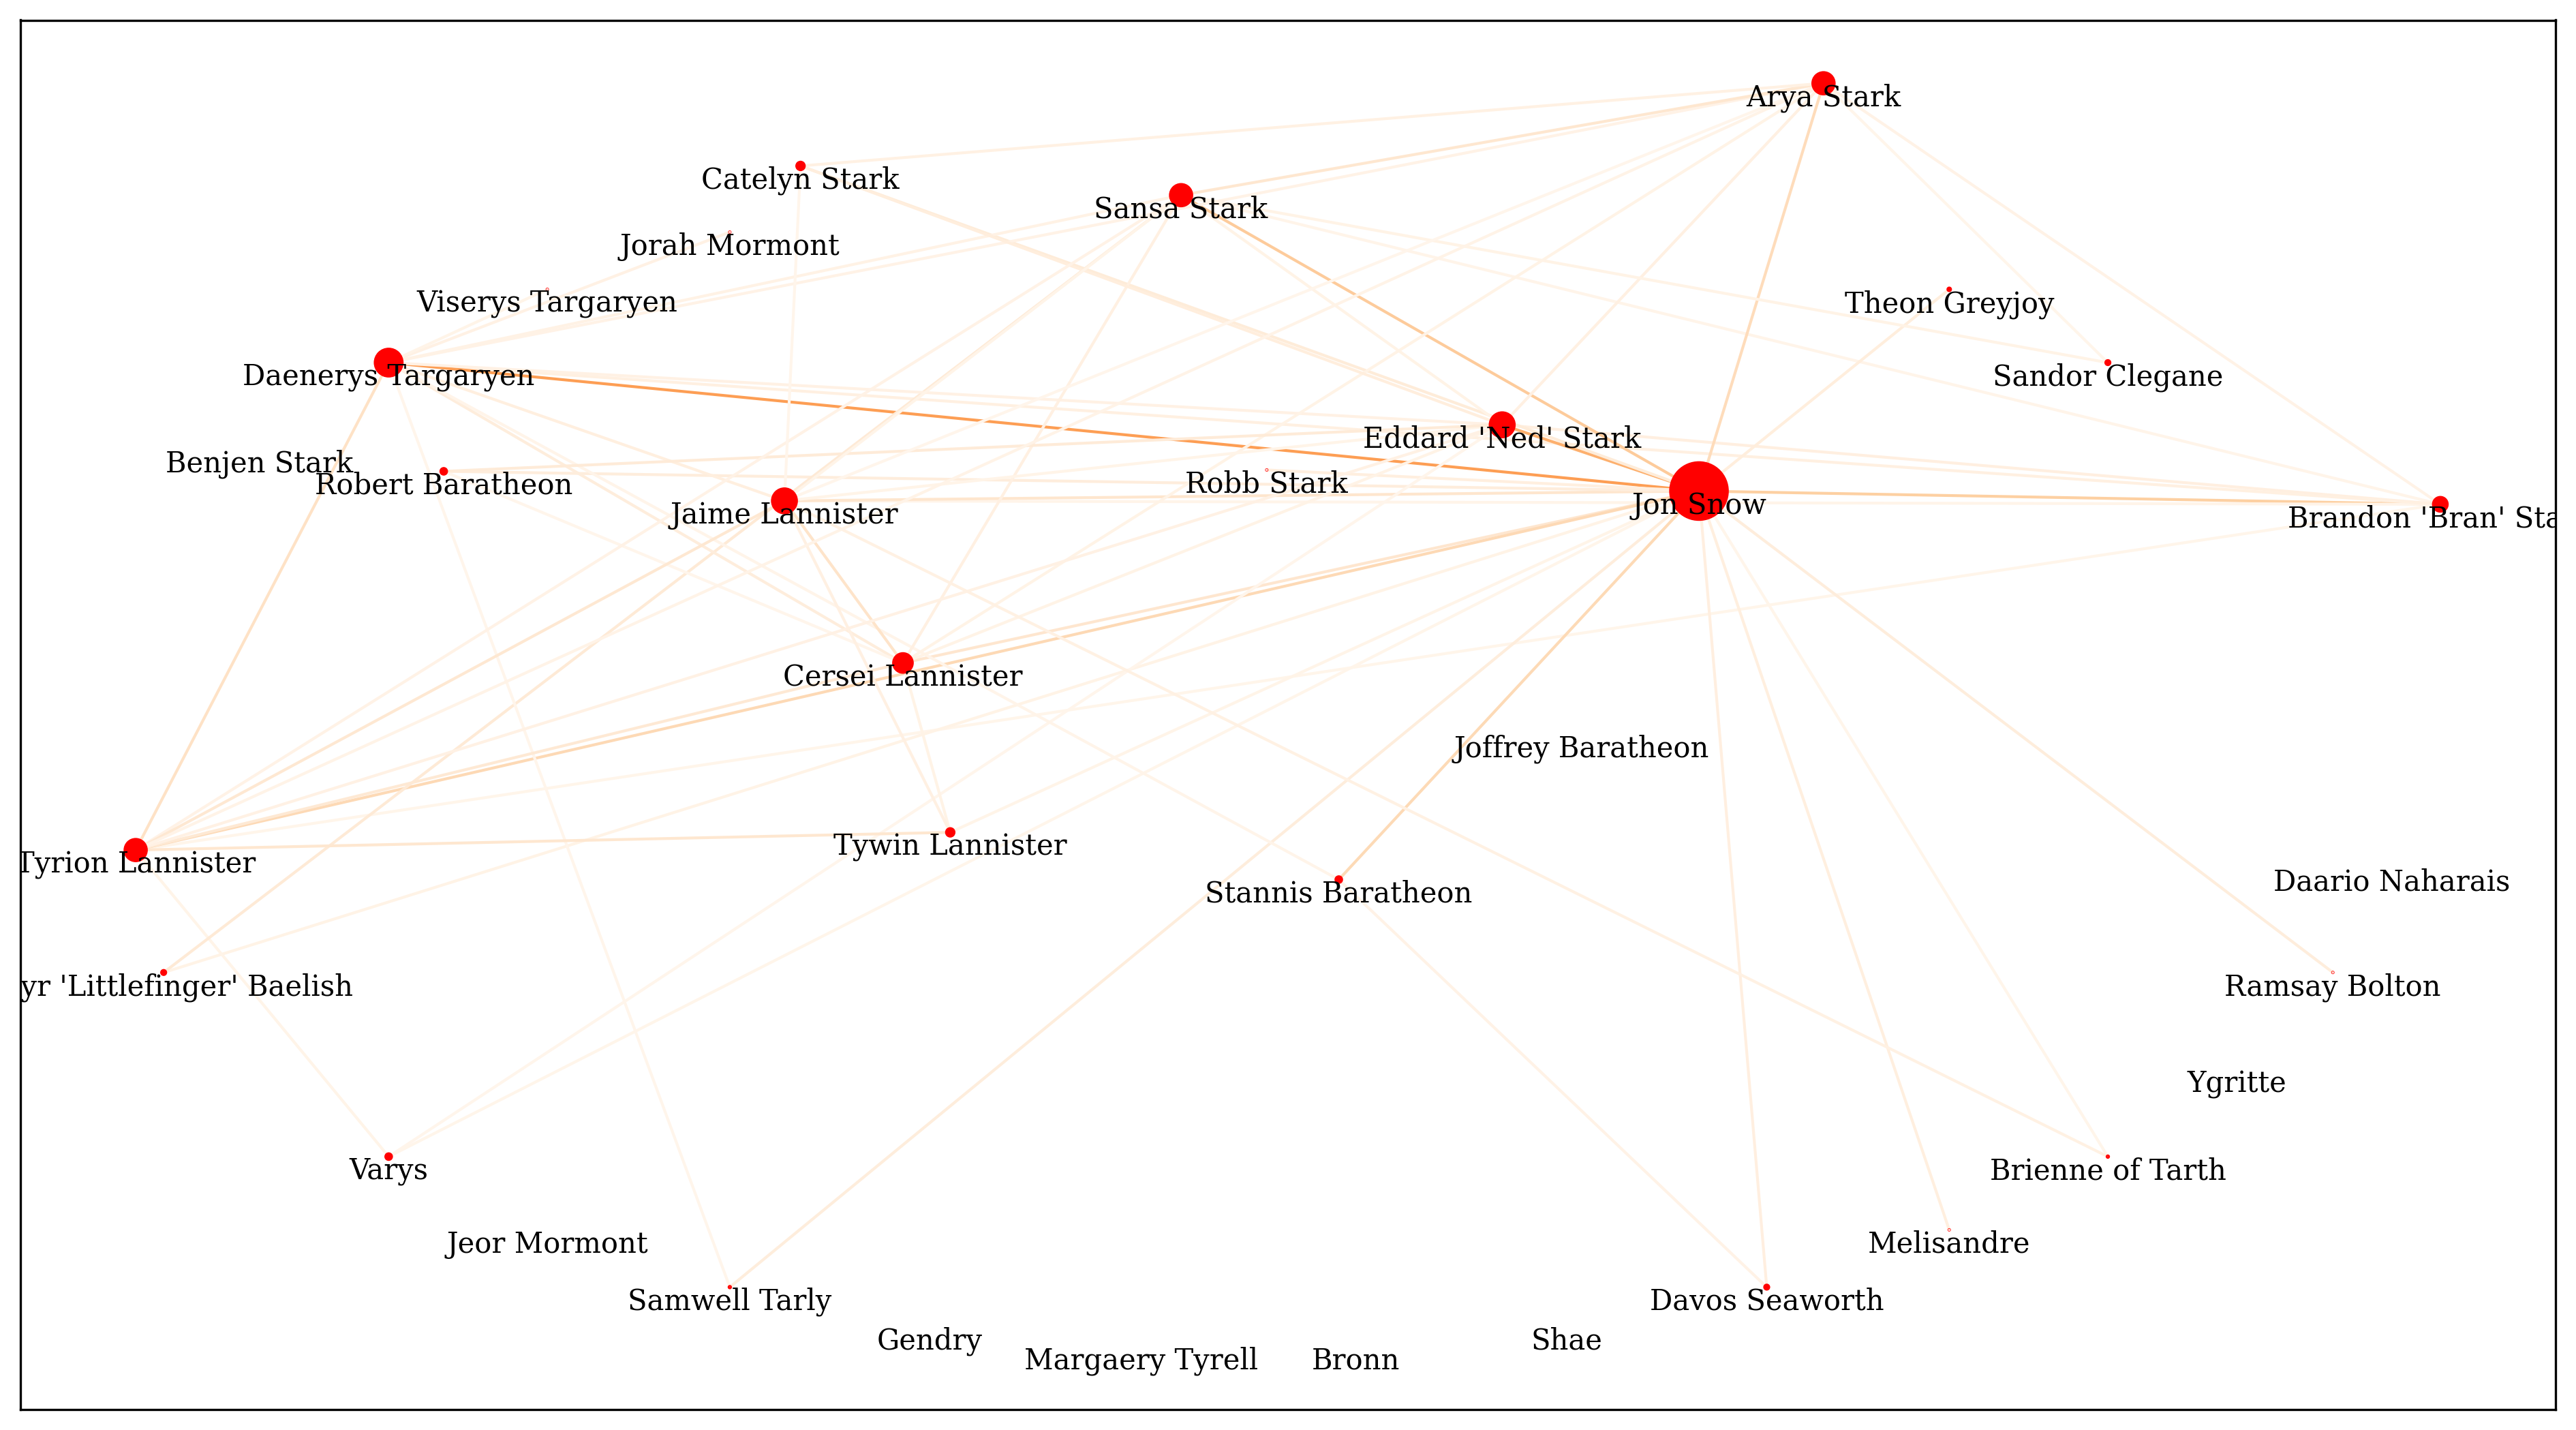

In [61]:
"""
INITIAL REDDIT GRAPH
"""
_ = plot_graph(G_reddit, weight_cutoff=0.05, pos=pos)

In [68]:
""" Weight distribution """
fig, ax = plt.subplots(figsize = (10, 5))

names = ("Books", "Reddit")
colours = "gr"

for i, G in enumerate((G_book, G_reddit)):
    weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    hist, edges = np.histogram(weights, bins=bins, density=True)

    x = (edges[1:] + edges[:-1])/2

    ax.plot(x[hist > 0], hist[hist > 0], marker='.', color="green", ls="--")
    ax.vlines([np.median(data), np.mean(data)], 0, 1, linewidth=3, colors=["r", "b"])

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Proportion of maximal co-mentions")
ax.set_ylabel("Probability density")

plt.show()
